# Project DD2434
## Run instructions
Tested in python 3.12.6, in a .venv environment

## Datasets
### Text document datasets
The original paper used 4 datsets from different newsgroups, sci.crypt, sci.med, sci.space and soc.religion.christian, which are available at `URL`

We also used `DATASET`

### Image datasets


The original paper used 13 monochromatic images of still life as the basis for the image datasets, which are unfortunately not available any longer. 




In [281]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import time
from copy import deepcopy
import sklearn
from torchvision import datasets, transforms
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

In [282]:
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
#plt.rcParams['text.usetex'] = False

# Set the font type for PDF output
plt.rcParams['pdf.fonttype'] = 42

In [283]:


import sklearn.decomposition


def normalizecolumns(d):
    """
    Return a matrix where the columns have unit length
    """
    """
    o = np.zeros(d.shape)
    for col in range(d.shape[1]):
        total_length = 0
        for row in range(d.shape[0]):
            total_length += d[(row,col)]**2
        
        for row in range(d.shape[0]):
            if total_length == 0:
                continue
            o[(row,col)] = d[(row,col)]/np.sqrt(total_length)"""
    norms = np.linalg.norm(d, axis=1, keepdims=True)
    norms[norms == 0] = 1
    return d/norms
    
    

def RP(dataset,k):
    """
    Dataset - d x N, where d is the # of dimensions, N is the # of data points.
    Creates appropriate matrix R (k x d), to transform into a lower dimension representation
    """
    d = dataset.shape[0]
    return normalizecolumns(np.random.normal(size=(k,d)))


def SRP(dataset,k):
    d = dataset.shape[0]
    o = np.zeros((k,d))
    values = [1,0,-1]
    probabilities = [1/6, 2/3, 1/6]
    o = np.random.choice(values, size=(k, d), p=probabilities)
    
    """
    for row in range(k):
        for col in range(d):
            r = np.random.random()
            if r < 1/6:
                o[(row,col)] = np.sqrt(3)
            elif r > 5/6:
                o[(row,col)] = -np.sqrt(3)"""
    return normalizecolumns(o*np.sqrt(3))

def SVD(dataset,k):
    """
    Returns d x k matrix, correponding to the k largest eigenvalues's eigenvectors.
    Calculated through TruncatedSVD method
    """
    svd = sklearn.decomposition.TruncatedSVD(n_components=k)
    X = np.asarray(dataset)
    svd.fit(X)

    # Get the singular values (Sigma_k) and the right singular vectors (V_k)
    Sigma_k = svd.singular_values_
    V_k = svd.components_  # Right singular vectors (k x n_features)
    
    # Compute the truncated U matrix: U_k = X @ V_k.T @ diag(1 / Sigma_k)
    U_k = (X @ V_k.T) / Sigma_k
    return U_k.T

def DCT(dataset,k):
    return(scipy.fft.dct(dataset,n = k,type=2,norm='ortho').transpose())

def PCA(dataset, k):
    pca = sklearn.decomposition.PCA(n_components=k)
    red_data = pca.fit_transform(np.asarray(dataset))
    return red_data.transpose()
    

In [284]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def similarity(v1,v2,v_type,d):
    """
    Returns a measurement of 
    ity, depending on the v_type. 
    """
    nv1 = normalize(v1)
    nv2 = normalize(v2)
    
    #nv1 = v1
    #nv2 = v2
    
    if v1.size == d:
        scale = 1
    else:
        k = v1.size
        scale = np.sqrt(d/k)
    
    if v_type == "text":
        return np.dot(nv1.transpose(),nv2)
    
    
    elif v_type == "image":
        return np.linalg.norm(nv1 - nv2) * scale
    else:
        raise ValueError("Invalid v_type, should be either 'text', or 'image'")
    
def add_noise_to_images(images_matrix):
    """
    Adds salt and pepper noise to images. With probabilities 0.1 black, 0.1 white.
    Image matrix has dimensions d x N
    """
    noisy_images = deepcopy(images_matrix)
    noise = np.random.rand(*images_matrix.shape)
    noisy_images[noise < 0.1] = 1  # Set to 1
    noisy_images[(noise >= 0.1) & (noise < 0.2)] = 0  # Set to 0
    return noisy_images

In [285]:
from tqdm import tqdm

# Dataset: d x N

def pipeline(dataset,method,v_type,numpairs,k_min,k_max,k_step,add_noise=False):
    
    N = dataset.shape[1]
    d = dataset.shape[0]
    
    match method:
        case "RP":
            methodfun = RP
        case "SRP":
            methodfun = SRP
        case "SVD":
            methodfun = SVD
        case "DCT":
            methodfun = DCT
        case "PCA":
            methodfun = PCA
        case _:
            raise ValueError("Invalid method string - choose from RP, SRP, SVD, DCT")
    # Select random pairs from the dataset
    pairs = []
    for i in range(numpairs):
        r1 = np.random.randint(N)
        r2 = np.random.randint(N)
        
        # Don't choose the same point twice
        while r2 == r1:
            r2 = np.random.randint(N)
        pairs.append([dataset[:,r1],dataset[:,r2]])
    
    output = {}
    all_sim_diffs = []
    runtimes      = []
    ks            = []
    average_errors = []
    error_std     = []
    summed_error = []
    
    if add_noise == True:
        noisy_dataset = add_noise_to_images(dataset)
    
    for k in tqdm(range(k_min,k_max,k_step)):
        t0 = time.time()
        # Tranformation matrix
        if add_noise == True:
            R = methodfun(noisy_dataset,k)
        else:
            R = methodfun(dataset,k)
        sim_diff_array = []
        for pair in pairs:
            x1 = pair[0]
            x2 = pair[1]
            
            tx1 = R * x1
            tx2 = R * x2
            
            sim_diff = similarity(x1,x2,v_type,d) - similarity(tx1,tx2,v_type,d)
            
            sim_diff_array.append(sim_diff)
        t1 = time.time()
        
        all_sim_diffs.append(np.mean(sim_diff_array))
        summed_error.append(np.sum(sim_diff_array))
        average_errors.append(np.average(sim_diff_array))
        error_std.append(np.std(sim_diff_array))
        
        runtimes.append(t1-t0)
        ks.append(k)
    output = {"method": method,
              "summed_sim_diffs": all_sim_diffs,
              "runtimes": runtimes,
              "summed_error": summed_error,
              "ks":ks,
              "type": v_type,
              "numpairs": numpairs,
              "average_errors": average_errors,
              "error_stds": error_std,
              "noisy?": add_noise}
    return output
    

In [286]:
def plot_results(iter_of_pipelines):
    
    methods = list(map(lambda x: x["method"],iter_of_pipelines))
    methodsstr = ', '.join(methods[:-1]) + ' and ' + methods[-1]
    
    noisy = iter_of_pipelines[0]["noisy?"]
    
    if noisy:
        titlestr = f"Average error using {methodsstr}, noisy data"
    else:
        titlestr = f"Average error using {methodsstr}"
    
    # Set up the figure with improved styling
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of dimensions in reduced space (k)", fontsize=14)
    plt.ylabel("Average Error", fontsize=14)
    plt.title(titlestr, fontsize=16)
    # Define marker styles for each method
    markers = {
        "RP": "+",
        "SRP": "*",
        "PCA": "s",
        "dct": "o"
    }
    for result in iter_of_pipelines:
        method           = result["method"]
        av_error         = result["average_errors"]
        std              = result["error_stds"]
        ks               = result["ks"]
        v_type           = result["type"]
        
        # Get marker style for the method, use a default if not specified
        marker = markers.get(method, "x")
        
        # Plot individual points with markers
        plt.scatter(ks, av_error, label=f"{method}", marker=marker, s=100)
        
        # Plot shaded area for standard deviation
        plt.fill_between(ks, 
                         [a - s for a, s in zip(av_error, std)], 
                         [a + s for a, s in zip(av_error, std)], 
                         alpha=0.2, label=f"{method} ± std")
    
    # Add legend and grid for better readability
    plt.legend(fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    
    # Save and show the plot
    plt.tight_layout()
    if noisy:
        plt.savefig(f"figures/{v_type}_average_errors_with_noise.pdf")
    else:
        plt.savefig(f"figures/{v_type}_average_errors.pdf")
    plt.show()
    
    if noisy:
        titlestr = f"Summed error using {methodsstr}, noisy data"
    else:
        titlestr = f"Summed error using {methodsstr}"
    
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of dimensions in reduced space (k)", fontsize=14)
    plt.ylabel("First error in similarity", fontsize=14)
    plt.title(titlestr, fontsize=16)
    for result in iter_of_pipelines:
        method           = result["method"]
        av_error         = result["average_errors"]
        std              = result["error_stds"]
        #error = result["first_diff"]
        ks               = result["ks"]
        summed_error     = result["summed_error"]
        noisy            = result["noisy?"]
        v_type           = result["type"]
        
        # Get marker style for the method, use a default if not specified
        marker = markers.get(method, "x")
        
        # Plot individual points with markers
        plt.scatter(ks, summed_error, label=f"{method}", marker=marker, s=100)
        
        # Plot shaded area for standard deviation
        plt.fill_between(ks, 
                         [a - s for a, s in zip(summed_error, std)], 
                         [a + s for a, s in zip(summed_error, std)], 
                         alpha=0.2, label=f"{method} ± std")
    
    # Add legend and grid for better readability
    plt.legend(fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    
    # Save and show the plot
    plt.tight_layout()
    if noisy:
        plt.savefig(f"figures/{v_type}_errors_with_noise.pdf")
    else:
        plt.savefig(f"figures/{v_type}_errors.pdf")
    plt.show()
    

In [287]:
transform = transforms.ToTensor()

class TinyImageNetTestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, fname) for fname in os.listdir(root) if fname.endswith(".JPEG")
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return image and its path

# Define a transform
transform = transforms.Compose([ 
    transforms.Grayscale(num_output_channels=1), # grayscale 
    transforms.ToTensor(),          # Convert to Tensor
])

# Instantiate the dataset
test_dataset = TinyImageNetTestDataset(root='./datasets/tiny-imagenet-200/test/images', transform=transform)



def maketextdataset(parent_folder_path, selected_folders):
    text_dataset = []
    k = 0
    for folder_name in selected_folders:
        folder_path = os.path.join(parent_folder_path, folder_name)
        for file_name in os.listdir(folder_path):
            k = k+1
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                    text_dataset.append(file.read())  # Read the content of the file

    vectoriser = CountVectorizer(stop_words='english', min_df= 20, max_df=0.8)
    #vectorizer = CountVectorizer(min_df=2, max_df=0.8)
    term_freq_mat = vectoriser.fit_transform(text_dataset)
    term_freq_mat = term_freq_mat.toarray()
    print(k)
    return term_freq_mat

def makeimagearray(i):
    image = test_dataset[i][0]
    image = np.squeeze(image)
    im_vec = np.reshape(image, (64**2,1))
    #print(im_vec.shape)
    return im_vec.numpy()

In [ ]:
D = np.matrix(np.array([makeimagearray(i) for i in range(1000)])).transpose()
selected_folders = ['sci.crypt/', 'sci.med/', 'sci.space/', 'soc.religion.christian/']
parent_folder_path = './datasets/20_newsgroups/'
T = np.matrix(maketextdataset(parent_folder_path, selected_folders))

3997


In [289]:
resultrp_im = pipeline(dataset=D,method="RP",v_type="image",numpairs=100,k_min=1,k_max=800,k_step=20)
resultsrp_im = pipeline(dataset=D,method="SRP",v_type="image",numpairs=100,k_min=1,k_max=800,k_step=20)
resultsvd_im = pipeline(dataset=D,method="PCA",v_type="image",numpairs=100,k_min=1,k_max=800,k_step=20)
resultdct_im = pipeline(dataset=D,method="DCT",v_type="image",numpairs=100,k_min=1,k_max=800,k_step=20)

100%|██████████| 40/40 [00:01<00:00, 30.21it/s]


In [290]:
resultrp_text = pipeline(dataset=T,method="RP",v_type="text",numpairs=100,k_min=1,k_max=650,k_step=20)
resultsvd_text = pipeline(dataset=T,method="SVD",v_type="text",numpairs=100,k_min=1,k_max=650,k_step=20)

100%|██████████| 33/33 [01:04<00:00,  1.95s/it]


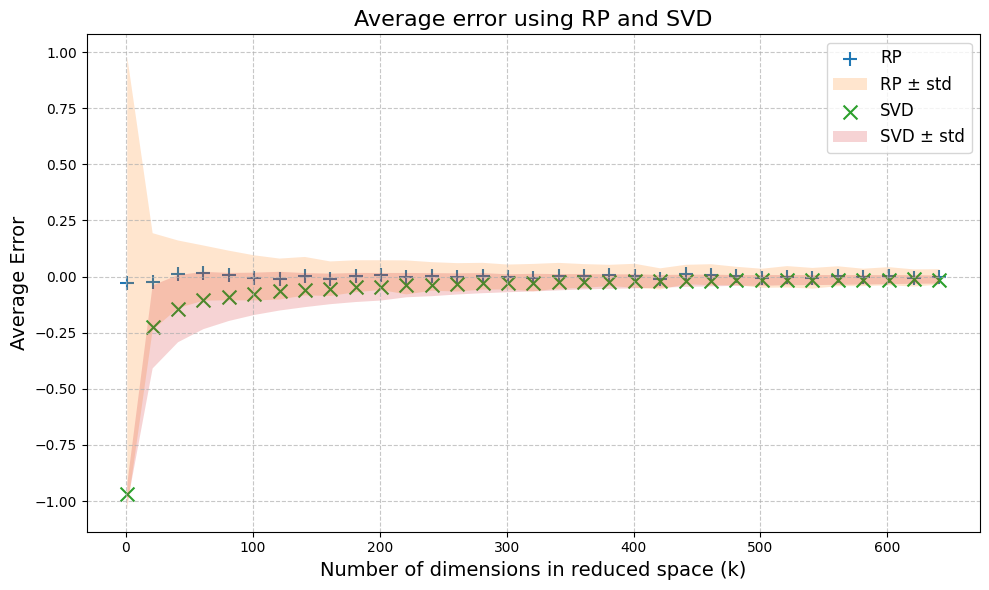

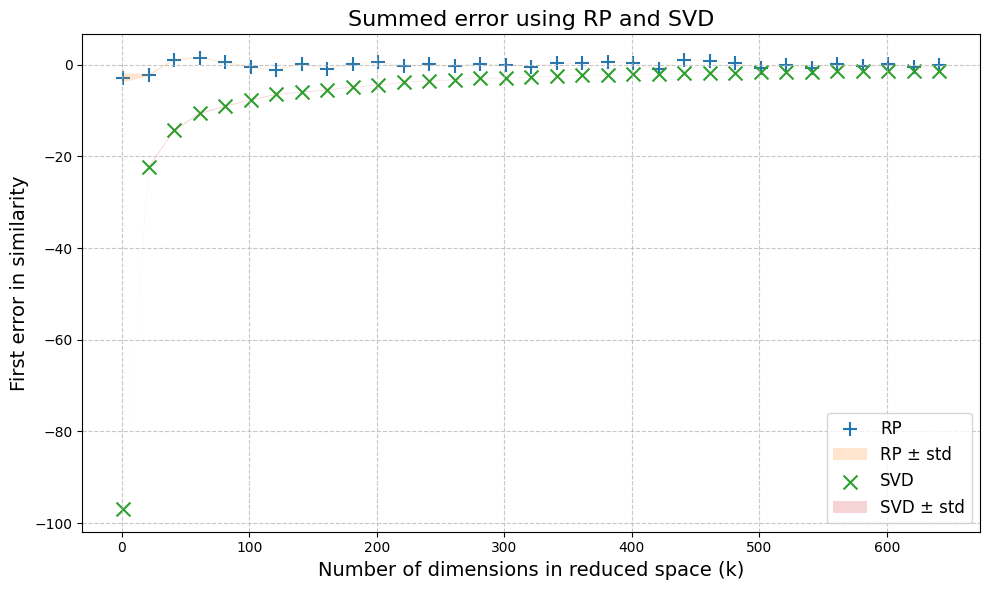

In [291]:
plot_results([resultrp_text, resultsvd_text])

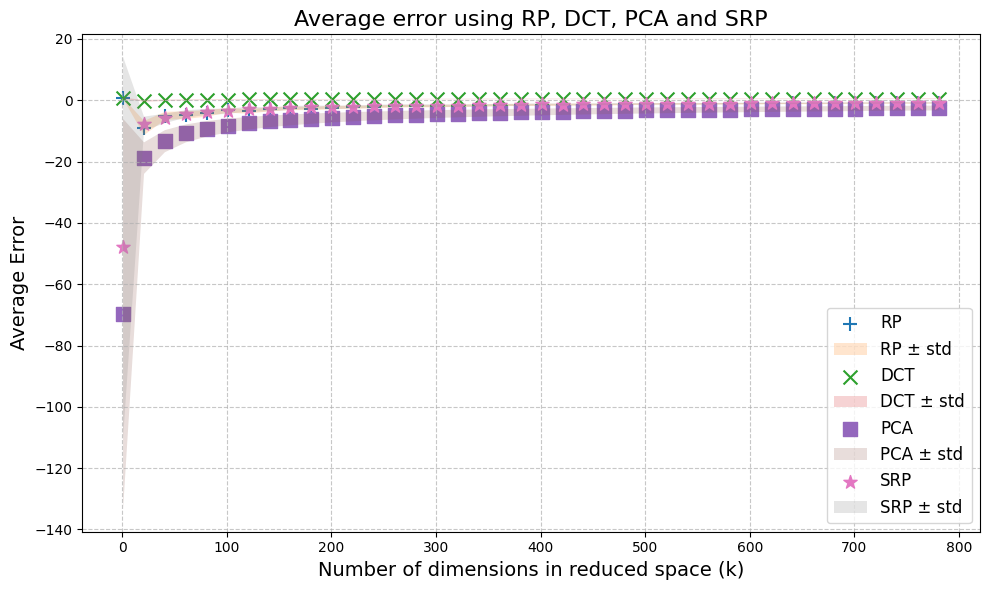

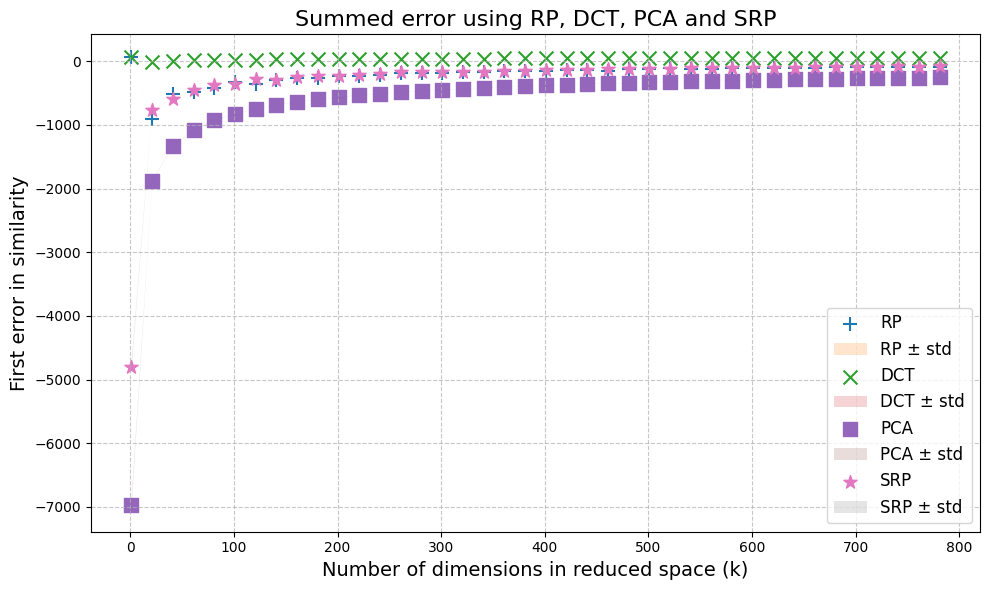

In [292]:
plot_results([resultrp_im,resultdct_im,resultsvd_im,resultsrp_im])

In [296]:
# Test images with noise applied

results_noisy_rp = pipeline(dataset=D,method="RP",v_type="image",numpairs=100,k_min=1,k_max=800,k_step=20,add_noise=True)
results_noisy_srp = pipeline(dataset=D,method="SRP",v_type="image",numpairs=100,k_min=1,k_max=800,k_step=20,add_noise=True)
results_noisy_dct = pipeline(dataset=D,method="DCT",v_type="image",numpairs=100,k_min=1,k_max=800,k_step=20,add_noise=True)
results_noisy_pca = pipeline(dataset=D,method="PCA",v_type="image",numpairs=100,k_min=1,k_max=800,k_step=20,add_noise=True)



100%|██████████| 40/40 [00:24<00:00,  1.64it/s]


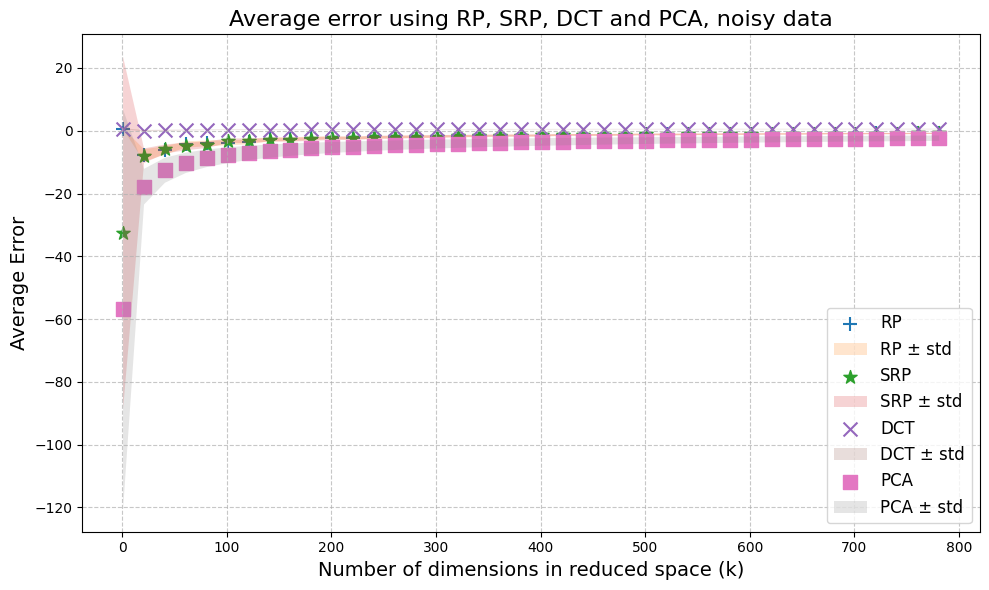

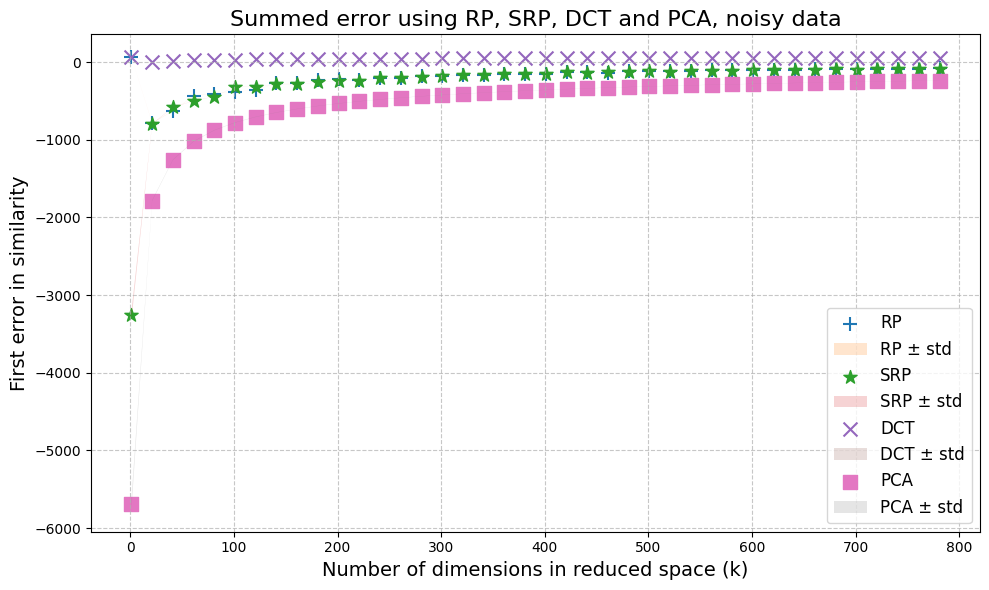

In [297]:
plot_results([results_noisy_rp,results_noisy_srp,results_noisy_dct,results_noisy_pca])

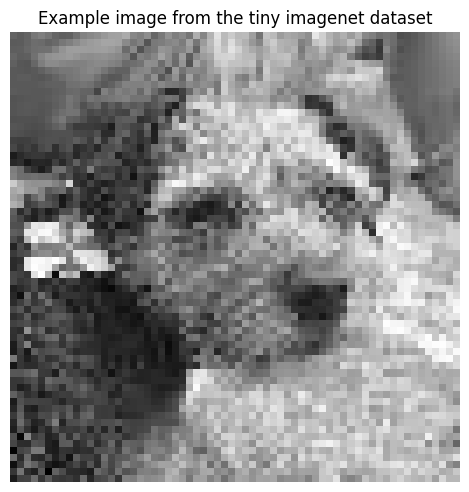

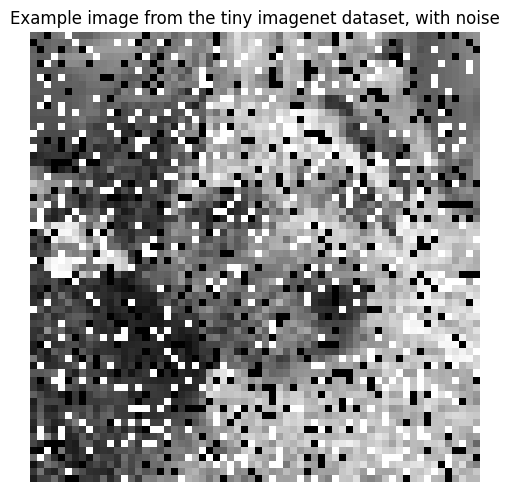

In [307]:
plt.figure()
plt.imshow(D[:,3].reshape((64,64)),cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.title("Example image from the tiny imagenet dataset")
plt.savefig("figures/example_figure_no_noise.pdf")

nD = add_noise_to_images(D)

plt.figure()
plt.imshow(nD[:,3].reshape((64,64)),cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.title("Example image from the tiny imagenet dataset, with noise")
plt.savefig("figures/example_figure_with_noise.pdf")